# Training Workbook for Supercomputer Environment

## Setup

Running setup scripts...


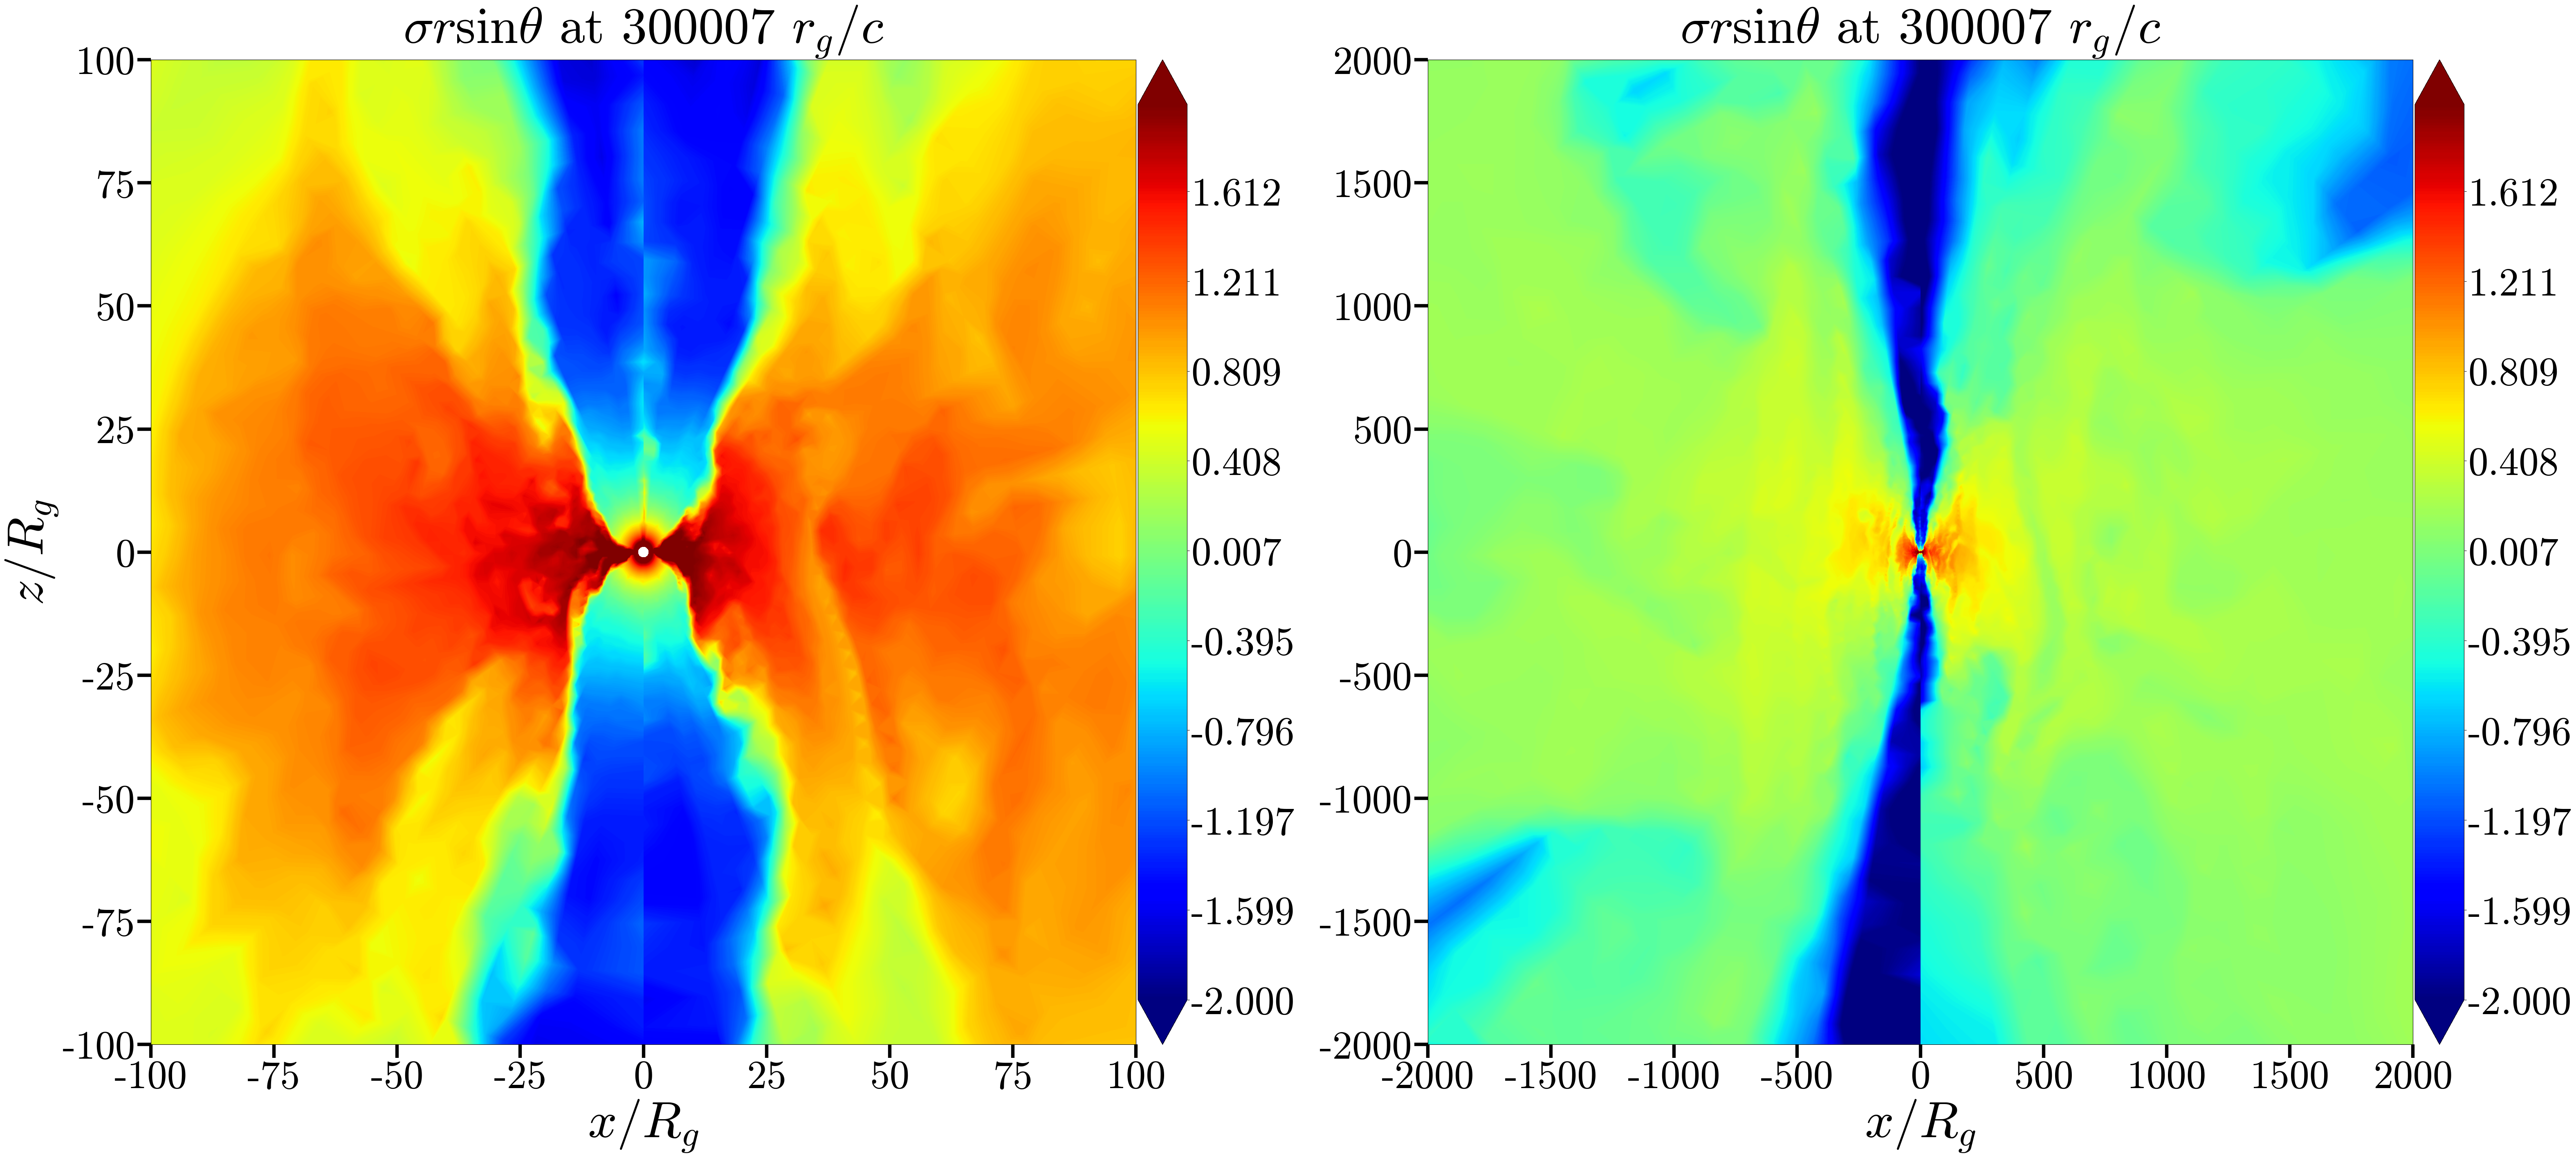

Read in dump 3000 in 1.8696 s
Plotted and saved in 2.5369 s
Read in dump 3001 in 3.6097 s
Plotted and saved in 2.6773 s
Read in dump 3002 in 3.6190 s
Plotted and saved in 2.5774 s
Read in dump 3003 in 1.7593 s
Plotted and saved in 2.7265 s
Read in dump 3004 in 2.0579 s
Plotted and saved in 2.5170 s
Read in dump 3005 in 1.8622 s
Plotted and saved in 2.6000 s
Read in dump 3006 in 2.0552 s
Plotted and saved in 2.6854 s
Read in dump 3007 in 1.8503 s
Plotted and saved in 3.1094 s
Read in dump 3008 in 1.7972 s
Plotted and saved in 2.5870 s
Read in dump 3009 in 1.8531 s
Plotted and saved in 2.5398 s
Read in dump 3010 in 1.5005 s
Plotted and saved in 2.5830 s
Read in dump 3011 in 2.1371 s
Plotted and saved in 2.5679 s
Read in dump 3012 in 2.0636 s
Plotted and saved in 2.5412 s
Read in dump 3013 in 1.6843 s
Plotted and saved in 2.5985 s
Read in dump 3014 in 2.0107 s
Plotted and saved in 2.5106 s
Read in dump 3015 in 1.9702 s
Plotted and saved in 2.4657 s
Read in dump 3016 in 1.5823 s
Plotted an

/global/u1/j/jackh/bh/harm2d/pp.py:3385: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(64, 32))


Plotted and saved in 2.7183 s
Read in dump 3021 in 2.1238 s
Plotted and saved in 2.7070 s
Read in dump 3022 in 2.1087 s
Plotted and saved in 2.5779 s
Read in dump 3023 in 2.1546 s
Plotted and saved in 2.6278 s
Read in dump 3024 in 2.1434 s
Plotted and saved in 2.5177 s
Read in dump 3025 in 1.9752 s
Plotted and saved in 2.4928 s
Read in dump 3026 in 1.9182 s
Plotted and saved in 2.4998 s
Read in dump 3027 in 2.2738 s
Plotted and saved in 2.5377 s
Read in dump 3028 in 1.9463 s
Plotted and saved in 2.5459 s
Read in dump 3029 in 1.9818 s
Plotted and saved in 2.4945 s
Read in dump 3030 in 1.8369 s
Plotted and saved in 2.6190 s
Read in dump 3031 in 1.8486 s
Plotted and saved in 2.7224 s
Read in dump 3032 in 2.1195 s
Plotted and saved in 2.6056 s
Read in dump 3033 in 2.1480 s
Plotted and saved in 2.6820 s
Read in dump 3034 in 2.4924 s
Plotted and saved in 2.5955 s
Read in dump 3035 in 2.7344 s
Plotted and saved in 2.5760 s
Read in dump 3036 in 2.4473 s
Plotted and saved in 3.3543 s
Read in du

In [11]:
## Setup and configs
# imports
import os
import time
import matplotlib
import matplotlib.pyplot as plt
# global variables
global notebook
global axisym,set_cart,axisym,REF_1,REF_2,REF_3,set_cart,D,print_fieldlines
global lowres1,lowres2,lowres3, RAD_M1, RESISTIVE, export_raytracing_GRTRANS, export_raytracing_RAZIEH,r1,r2,r3
global r_min, r_max, theta_min, theta_max, phi_min,phi_max, do_griddata, do_box, check_files, kerr_schild

notebook = 1

# total data is shape (10000, 224, 48, 96)
# harm_directory = '/global/u1/j/jackh/bh/harm2d'
# harm_directory = '/global/homes/a/arjuna/bh/harm2d'
harm_directory = os.environ['HOME']+f'/bh/harm2d'
os.chdir(harm_directory)

print(f'Running setup scripts...')
start_time = time.time()
%run -i setup.py build_ext --inplace
%run -i pp.py build_ext --inplace
print(f"Execution time: {time.time() - start_time}")

# set params
lowres1 = 1 # 
lowres2 = 1 # 
lowres3 = 1 # 
r_min, r_max = 1.0, 100.0
theta_min, theta_max = 0.0, 9
phi_min, phi_max = -1, 9
do_box=0
set_cart=0
set_mpi(0)
axisym=1
print_fieldlines=0
export_raytracing_GRTRANS=0
export_raytracing_RAZIEH=0
kerr_schild=0
DISK_THICKNESS=0.03
check_files=1
notebook=1
interpolate_var=0
AMR = 0 # get all data in grid

print('Imports and setup done.')
%matplotlib inline

## Training

In [4]:
# imports
import numpy as np
import torch
from tqdm import tqdm

# training utilities
from utils.sc_utils import custom_batcher, tensorize_globals
from models.cnn.cnn import CNN_3D

# path to dumps
dumps_path = '/pscratch/sd/l/lalakos/ml_data_rc300/reduced'
os.chdir(dumps_path)
# number of data points
num_dumps = 11 - 1
# batch size
batch_size = 2
# number of epochs
num_epochs = 2

# access device, cuda device if accessible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set model
model = CNN_3D().to(device)
# set loss
optim = torch.optim.Adam(params=model.parameters())
loss_fn = torch.nn.MSELoss()

# get indexes for training data
train_indexes, validation_indexes = custom_batcher(
    batch_size=batch_size,
    num_dumps=num_dumps,
    split = 0.8,
    seed=1
)

num_train_batches = len(train_indexes)//batch_size
num_valid_batches = len(validation_indexes)//batch_size

best_validation = float('inf')

rgdump_griddata(dumps_path)

for epoch in range(num_epochs):
    ## Training
    model.train()
    epoch_train_loss = []

    # shuffle training indexes
    np.random.shuffle(train_indexes)

    # list of average train/validation losses after each epoch
    train_losses, valid_losses = [], []

    prog_bar = tqdm(enumerate(train_indexes.reshape(-1, batch_size)), total=num_train_batches)
    for batch_num, batch_indexes in prog_bar:
        ## fetch and tensorize data
        # NOTE everything is a global variable so it has to be this way. im sorry
        batch_data, label_data = [], []
        # batch_idx is the dump number
        for batch_idx in batch_indexes:

            # at every batch of size batch_size, we need to read in 2 * batch_size dumps
            
            ## get data frame
            # get data into global context NOTE this is really slow
            rblock_new(batch_idx)
            rpar_new(batch_idx)
            rdump_griddata(dumps_path, batch_idx)
            # format data as tensor
            data_tensor = tensorize_globals(rho=rho, ug=ug, uu=uu, B=B)
            # add to batch
            batch_data.append(data_tensor)

            ## get label frame
            # get data into global context
            rblock_new(batch_idx+1)
            rpar_new(batch_idx+1)
            rgdump_griddata(dumps_path)
            rdump_griddata(dumps_path, batch_idx+1)
            # format data as tensor
            data_tensor = tensorize_globals(rho=rho, ug=ug, uu=uu, B=B)
            # add to batch
            label_data.append(data_tensor)

        # final tensorize
        batch_data = torch.cat(batch_data, dim=0).to(device)
        label_data = torch.cat(label_data, dim=0).to(device)

        ## train model
        # make prediction
        pred = model.forward(batch_data)
        # compute loss
        loss_value = loss_fn(pred, label_data)
        epoch_train_loss.append(loss_value)
        # backprop
        loss_value.backward()
        # update paramts
        optim.step()

        prog_bar.set_description(f'Train batch {batch_num+1} completed with loss {loss_value.item():.4f}')

    # training loss tracking
    avg_loss_after_epoch = sum(epoch_train_loss)/len(epoch_train_loss)
    train_losses.append(avg_loss_after_epoch)
    print(f"Train loss value: {avg_loss_after_epoch}")


    ## Validation
    model.eval()
    epoch_valid_loss = []

    prog_bar = tqdm(enumerate(validation_indexes.reshape(-1, batch_size)), total=num_valid_batches)
    for batch_num, batch_indexes in prog_bar:
        ## fetch and tensorize data
        # NOTE everything is a global variable so it has to be this way. im sorry
        batch_data, label_data = [], []
        # batch_idx is the dump number
        for batch_idx in batch_indexes:
            ## get data frame
            # get data into global context
            rblock_new(batch_idx)
            rpar_new(batch_idx)
            rgdump_griddata(dumps_path)
            rdump_griddata(dumps_path, batch_idx)
            # format data as tensor
            data_tensor = tensorize_globals(rho=rho, ug=ug, uu=uu, B=B)
            # add to batch
            batch_data.append(data_tensor)

            ## get label frame
            # get data into global context
            rblock_new(batch_idx+1)
            rpar_new(batch_idx+1)
            rgdump_griddata(dumps_path)
            rdump_griddata(dumps_path, batch_idx+1)
            # format data as tensor
            data_tensor = tensorize_globals(rho=rho, ug=ug, uu=uu, B=B)
            # add to batch
            label_data.append(data_tensor)

        # final tensorize
        batch_data = torch.cat(batch_data, dim=0).to(device)
        label_data = torch.cat(label_data, dim=0).to(device)

        # make prediction
        pred = model.forward(batch_data)

        # compute loss
        loss_value = loss_fn(pred, label_data)
        epoch_valid_loss.append(loss_value)
        
        prog_bar.set_description(f'Validation batch {batch_num+1} completed with loss {loss_value.item():.4f}.')
        
    avg_vloss_after_epoch = sum(epoch_train_loss)/len(epoch_train_loss)
    valid_losses.append(avg_vloss_after_epoch)
    print(f"Valid loss value: {avg_loss_after_epoch}")

    # checkpointing
    if avg_vloss_after_epoch < best_validation:
        best_validation = avg_vloss_after_epoch
        save_path = os.environ['HOME'] + '/bh/' + model.save_path
        model.save(save_path=save_path)

# plot learning
plt.plot([i for i in range(len(train_losses))], [loss.item() for loss in train_losses], label='Train Loss')
# plt.plot([i for i in range(len(train_losses))], [avg_baseline_loss for _ in range(len(train_losses))], label='Predicting Avg Loss', linestyle='dashed')
plt.plot([i for i in range(len(valid_losses))], [loss.item() for loss in valid_losses], label='Validation Loss')
plt.title(f'Training and Validation Curve')
plt.xlabel(f'Number of Batches')
plt.ylabel(f'Loss (MSE)')
plt.legend()
plt.show()


  0%|          | 0/4 [00:05<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 28 but got size 224 for tensor number 1 in the list.

## Visualization

In [1]:
# load in model
import os
import torch
from models.cnn.cnn import CNN_3D

# access device, cuda device if accessible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = os.environ['HOME'] + '/bh/models/cnn/saves/3dcnn_v0.0.0.pth'
model = CNN_3D()
model.load_state_dict(torch.load(f=model_path))
model = model.to(device)
print(f'Model loaded.')

Model loaded.


In [2]:
from utils.anim import make_prediciton_frames

os.chdir(os.environ['HOME'] + '/bh/')

# access device, cuda device if accessible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_path = os.environ['HOME']+'/bh/data.pkl'
data = torch.load(f=save_path)
# print(data.shape)

predictions, latents = make_prediciton_frames(
    net=model,
    first_frame=data[0].unsqueeze(0), 
    make_latents=False,
    num_frames=10,
    device=device
)

# animate
# animate_preds(
#     predictions = predictions, 
#     save_path = './movies/preds_movie.gif',
#     cb = True
# )

NameError: name 'animate_preds' is not defined

In [3]:
print(len(predictions))

10
